### Check input files



In [38]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('../datasets'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


../datasets/train_data.csv
../datasets/firstDataset.csv


### Import train data and create DataFrame object

In [39]:
rawsData = pd.read_csv('../datasets/firstDataset.csv')
print("The files have been imported")


The files have been imported


In [40]:
rawsData = rawsData.drop(['Timestamp'], axis=1)


In [41]:
len(rawsData)


1048575

In [42]:
rawsData.keys()


Index(['Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts',
       'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
       'Fwd Seg Siz

In [43]:
LABEL = 'Label'
NORMAL = 'Benign'
FTP = 'FTP-BruteForce'
SSH = 'SSH-Bruteforce'


In [44]:
# rawNormal = rawsData[rawsData[LABEL] == NORMAL]
# rawFTP = rawsData[rawsData[LABEL] == FTP]
# rawSSH = rawsData[rawsData[LABEL] == SSH]


In [45]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
# import plotly as py
# import plotly.express as px
init_notebook_mode(connected=True)


def showAttackDistribution(data):
    counted = data.value_counts()

    fig = go.Figure(data=[
        go.Bar(name=NORMAL,
               y=[counted[NORMAL]],
               x=[NORMAL],
               text=str(counted[NORMAL]),
               orientation='v',
               textposition='outside',),
        go.Bar(name=FTP,
               y=[counted[FTP]],
               x=[FTP],
               text=str(counted[FTP]),
               orientation='v',
               textposition='outside',),
        go.Bar(name=SSH,
               y=[counted[SSH]],
               x=[SSH],
               text=str(counted[SSH]),
               orientation='v',
               textposition='outside',)
    ])
    # Change the bar mode
    fig.update_layout(
        width=800,
        height=600,
        title=f'Labels Distribution',
        yaxis_title='Number of attacks',
        xaxis_title='Attack Name',)
    iplot(fig)


In [46]:
showAttackDistribution(rawsData['Label'])


In [47]:
def getSliceFromRawData():
    return rawsData[['Protocol',
                     'Fwd Pkt Len Max',
                     'Fwd Pkt Len Max',
                     'Bwd Pkt Len Mean',
                     'Fwd Pkt Len Std',
                     'Bwd Pkt Len Max',
                     'Bwd Pkt Len Min',
                     'Bwd Pkt Len Std',
                     'Bwd IAT Tot',
                     'Bwd IAT Mean',
                     'Bwd IAT Max',
                     'Pkt Len Min',
                     'Pkt Len Max',
                     'PSH Flag Cnt',
                     'Fwd Header Len',
                     'SYN Flag Cnt',
                     'RST Flag Cnt',
                     'ACK Flag Cnt',
                     'URG Flag Cnt',
                     'ECE Flag Cnt',
                     'Fwd Seg Size Avg',
                     'Init Fwd Win Byts',
                     'Fwd Act Data Pkts',
                     'Fwd Seg Size Min',
                     'Down/Up Ratio',
                     'Bwd Pkts/s',
                     'Fwd Pkts/s',
                     'Pkt Size Avg',
                     'Idle Mean',
                     'Label']].copy()


In [48]:
selectedData = getSliceFromRawData()
allDatasetToTest = getSliceFromRawData()

# selectedData = rawsData.copy()
# allDatasetToTest = rawsData.copy()


In [49]:
withoutDuplicates = selectedData.drop_duplicates().copy()
withoutDuplicates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 604504 entries, 0 to 1048574
Data columns (total 30 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Protocol           604504 non-null  int64  
 1   Fwd Pkt Len Max    604504 non-null  int64  
 2   Fwd Pkt Len Max    604504 non-null  int64  
 3   Bwd Pkt Len Mean   604504 non-null  float64
 4   Fwd Pkt Len Std    604504 non-null  float64
 5   Bwd Pkt Len Max    604504 non-null  int64  
 6   Bwd Pkt Len Min    604504 non-null  int64  
 7   Bwd Pkt Len Std    604504 non-null  float64
 8   Bwd IAT Tot        604504 non-null  int64  
 9   Bwd IAT Mean       604504 non-null  float64
 10  Bwd IAT Max        604504 non-null  int64  
 11  Pkt Len Min        604504 non-null  int64  
 12  Pkt Len Max        604504 non-null  int64  
 13  PSH Flag Cnt       604504 non-null  int64  
 14  Fwd Header Len     604504 non-null  int64  
 15  SYN Flag Cnt       604504 non-null  int64  
 16  R

In [50]:
showAttackDistribution(withoutDuplicates[LABEL])


In [51]:
def shortData(data, featureName):
    shortedNormal = data[data[featureName] ==
                         NORMAL].sample(100, ignore_index=True, random_state=32)
    shortedFTP = data[data[featureName] == FTP].sample(10, ignore_index=True, random_state=32)
    shortedSSH = data[data[featureName] == SSH].sample(100, ignore_index=True, random_state=32)
    return pd.concat([shortedNormal, shortedFTP, shortedSSH], axis=0)


In [52]:
toTrainModel = shortData(withoutDuplicates, LABEL).copy()
showAttackDistribution(toTrainModel[LABEL])


In [53]:

def makeOnlyAttackOrNot(dataToTransform):
    columnToTransform = [LABEL]
    for colKey in columnToTransform:
        dataToTransform[colKey] = dataToTransform[colKey].map(
            lambda i: 0 if i == NORMAL else 1)
        # dataToTransform[colKey] = LabelEncoder().fit_transform(dataToTransform[colKey])

    return dataToTransform


In [54]:
toTrainModel = makeOnlyAttackOrNot(toTrainModel)
allDatasetToTest = makeOnlyAttackOrNot(allDatasetToTest)

In [55]:
def removeNanInf(data):
    maxNonInf = data.max().loc[lambda value: value < np.Inf].max()
    data = data.replace(np.nan, 0)
    data = data.replace(np.inf, maxNonInf)
    return data

In [56]:
toTrainModel = removeNanInf(toTrainModel)
allDatasetToTest = removeNanInf(allDatasetToTest)

In [57]:
# from sklearn.preprocessing import StandardScaler


# def scale(dataToTransform, columntoTransform):

#     ss_dict = {col: StandardScaler() for col in columntoTransform}

#     for colKey in columntoTransform:
#         dataToTransform[colKey] = ss_dict[colKey].fit_transform(
#             np.array(dataToTransform[colKey]).reshape(-1, 1))

#     return dataToTransform


In [58]:
# numericColumntoTransform = withoutDuplicates.keys()
# withoutDuplicates = scale(withoutDuplicates, numericColumntoTransform)


### Heatmap
#### Heatmap provide us information on how much the individual features are interpedent. 

<AxesSubplot:>

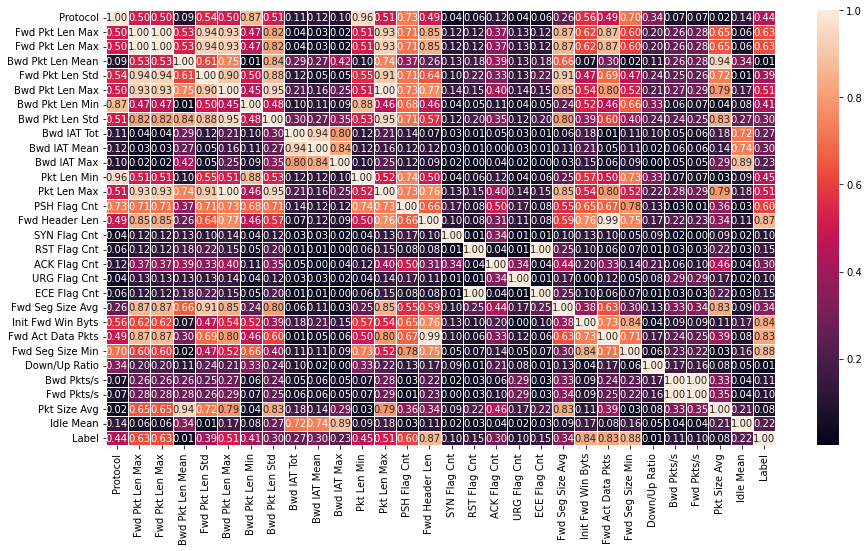

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

f, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(abs(toTrainModel.corr()), annot=True,
            linewidths=0.5, fmt='.2f', ax=ax)


Save label

In [60]:
labels = toTrainModel[LABEL]
toTrainModel = toTrainModel.drop([LABEL], axis=1)


In [61]:
def printNanFinite(data):
    print('Is any Nan:', np.any(np.isnan(data)))
    print('Is all finite:', np.all(np.isfinite(data)))


In [62]:
printNanFinite(toTrainModel)
print('\n')
printNanFinite(allDatasetToTest)


Is any Nan: False
Is all finite: True


Is any Nan: False
Is all finite: True


Scale numeric values

#### After preprocess

In [63]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    toTrainModel, labels, test_size=0.33, random_state=32)


X_train.to_csv('X_train.csv')
X_test.to_csv('X_test.csv')
y_train.to_csv('y_train.csv')
y_test.to_csv('y_test.csv')


In [64]:
isRFC = True
isMLPC = False
isSequential = False


In [65]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Dense


def model():
    if isRFC:
        model = RandomForestClassifier(
            n_estimators=100, max_depth=5, min_samples_leaf=4)
    elif isMLPC:
        model = MLPClassifier(random_state=32)
    else:
        model = Sequential([
            Dense(256, activation='softplus', kernel_initializer='glorot_uniform',
                  input_dim=X_train.shape[1]),
            Dense(128, activation='softplus',
                  kernel_initializer='glorot_uniform'),
            Dense(1, kernel_initializer='glorot_uniform', activation='sigmoid')
        ])

        model.compile(loss='binary_crossentropy',
                      optimizer='Adam')

    return model


In [66]:
model = model()


In [67]:
model.fit(X_train, y_train)


RandomForestClassifier(max_depth=5, min_samples_leaf=4)

In [68]:

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def confMatrix(yTrain, xTrainPreds, yTest, xTestPreds):
    # Your code here
    cmTrain = confusion_matrix(yTrain, xTrainPreds)
    X_train_disp = ConfusionMatrixDisplay(confusion_matrix=cmTrain)

    cmTest = confusion_matrix(yTest, xTestPreds)
    X_test_disp = ConfusionMatrixDisplay(confusion_matrix=cmTest)
    # End

    _, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=150)

    X_train_disp.plot(ax=ax[0])
    ax[0].set_title("Train")

    X_test_disp.plot(ax=ax[1])
    ax[1].set_title("Test")
    plt.show()


In [69]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

def printScores(name, labels, predicts):
    print(name )
    print('Accuracy: %.3f ' % accuracy_score(labels, predicts))
    print('Precision: %.3f ' % precision_score(labels, predicts))
    print('Recall: %.3f' % recall_score(labels, predicts))
    print('F1 Score: %.3f' % f1_score(labels, predicts))
    print('\n')

In [70]:


X_train_preds = model.predict(X_train)
X_test_preds = model.predict(X_test)

if isSequential:
    print('Train auc:', roc_auc_score(y_train, X_train_preds))
    print('Test auc:', roc_auc_score(y_test, X_test_preds))
else:
    printScores('Train:', y_train, X_train_preds)
    printScores('Test:', y_test, X_test_preds)


Train:
Accuracy: 1.000 
Precision: 1.000 
Recall: 1.000
F1 Score: 1.000


Test:
Accuracy: 1.000 
Precision: 1.000 
Recall: 1.000
F1 Score: 1.000




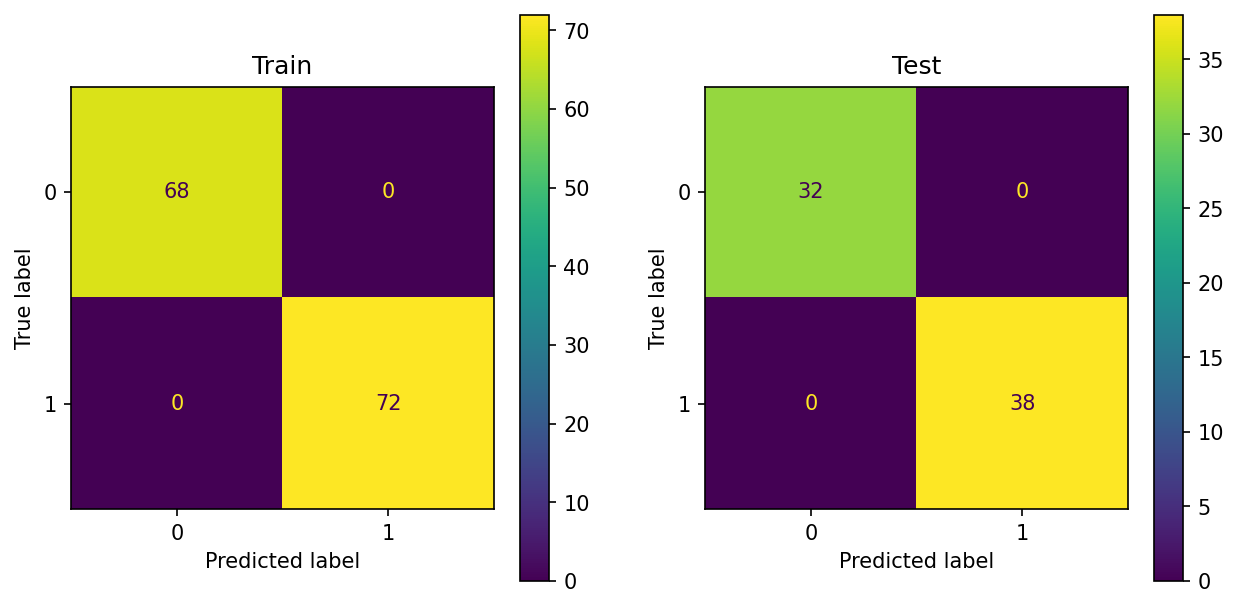

In [71]:
confMatrix(y_train, X_train_preds, y_test, X_test_preds)


In [72]:
allDatasetLabels = allDatasetToTest[LABEL]
allDatasetToTest = allDatasetToTest.drop([LABEL], axis=1)

allDatasetLabels.to_csv('allDatasetLabels.csv')
allDatasetToTest.to_csv('allDatasetToTest.csv')


In [73]:


AllDatasetPreds = model.predict(allDatasetToTest)

if isSequential:
    print('Auc:', roc_auc_score(allDatasetLabels, AllDatasetPreds))
else:
    printScores('All dataset:', allDatasetLabels, AllDatasetPreds)


All dataset:
Accuracy: 0.910 
Precision: 0.999 
Recall: 0.754
F1 Score: 0.859




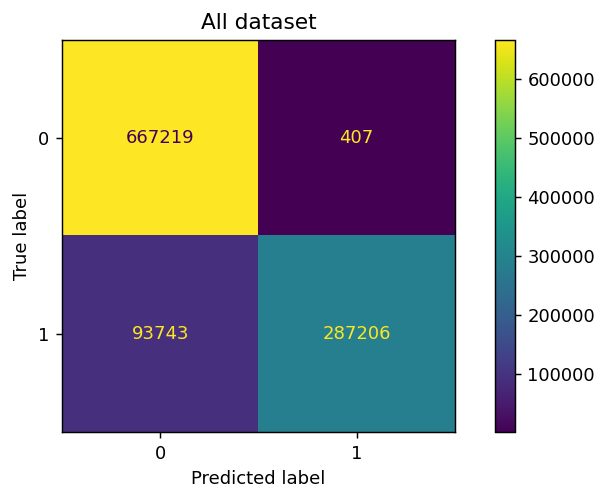

In [74]:
allDatasetConfusionMatrix = confusion_matrix(allDatasetLabels, AllDatasetPreds)
allDataSetMatrixDisplay = ConfusionMatrixDisplay(confusion_matrix=allDatasetConfusionMatrix)
_, ax = plt.subplots(figsize=(8, 4), dpi=130)
ax.set_title("All dataset")
allDataSetMatrixDisplay.plot(ax=ax)
plt.show()
